<a href="https://colab.research.google.com/github/Caleb-Flegel/CS2---Code-Example/blob/master/Two_Slit_Bright_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Partner: Zach Washburn

Date: 9/20/2022

# Objectives
* To measure both of the slit widths in the double slit slide using
their respective single-slit diffraction patterns.
* To determine the laser wavelength using by fitting the Fraunhofer
model for two-slit interference to the observed intensity pattern.


# Install and import libraries

In [1]:
!pip install whit-phys-util 1>/dev/null
!pip install xlrd --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.8 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import whit_phys_util as buc

# Connect to GitHub

In [3]:
repo = buc.local_repository("https://github.com/PS251-FA22/two-slit-bright-1b")

Repository exists at this location. Pulling changes from GitHub.


# Equipment

| Description | Manufacturer | Model | ID or SN |
| ----------- | ------------ | ----- | -------- |
| Two-slit interference, one-photon-at-a-time apparatus | TeachSpin | TWS 2-A | TWS 383 |
| multimeter | Fluke | 179 | 58870154 |


# Slit-blocker positions
* Far slit unblocked: 4.35 mm
* Both unblocked: 5.65 mm
* Near slit unblocked: 6.09 mm

In [4]:
distanceToDetector = 19100 # distance from double-slit to detector in mm

19100 mm

# Key landmarks in the interference pattern

| Label | Location (mm) | Photodiode Voltage (V) | 
| ----- | ------------- | ---------------------- |
|$\mathrm{3_f}$ | 3.41 | 0.600 |
|$\mathrm{2_f}$ | 4.21 | 1.549 |
|$\mathrm{1_f}$ | 5.15 | 2.498 |
|$0$            | 5.81 | 2.809 | 
|$\mathrm{1_n}$ | 6.72 | 2.498 |
|$\mathrm{2_n}$ | 7.50 | 1.521 |
|$\mathrm{3_n}$ | 8.26 | 0.588 |

We encountered good differences in volts and location between the three peaks we measured in either direction of the maximum. One possible issues is that our peak voltage is lower than it ideally should be. 

# Import Data

In [5]:
df_near = pd.read_excel("Two Slit Bright Data.xlsx", "Near Slit Only")
df_far = pd.read_excel("Two Slit Bright Data.xlsx", "Far Slit Only")
df_both = pd.read_excel("Two Slit Bright Data.xlsx", "Both Slits")

In [6]:
x = df_near['Location (mm)'] - 5.81
V_near = df_near['Photodiode Voltage (V)']
V_far = df_far['Photodiode Voltage (V)']
V_both = df_both['Photodiode Voltage (V)']

# Single Slit Diffraction

In [17]:
def I_ss(x, I0, a, x0): 
  wavelength = 0.000670 # 670 nm converted to mm
  q = np.arctan((x-x0) / distanceToDetector)
  return I0*np.sinc( a*np.sin(q)/wavelength )**2

param, cov = curve_fit(I_ss, df_far['Location (mm)'], df_far['Photodiode Voltage (V)'], p0=[.734, .1, -.5])

In [18]:
from whit_phys_util.pretty_fit import fitTable
fitTable = buc.fitTable(param, cov, paramLabels=['I0', 'a', 'x0'])
fitTable

,I0,a,x0
value,0.735945,3.534052,5.422231
uncertainty,0.001084,0.010065,0.003032


In [ ]:
df_far['Best fit'] = I_ss(df_far["Location (mm)"])

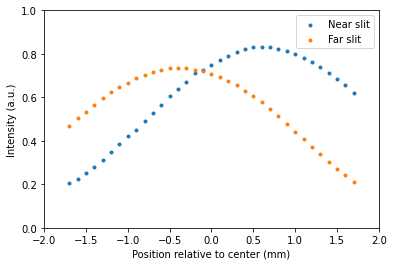

In [8]:
fig_ss, ax_ss = plt.subplots();

ax_ss.scatter(x, V_near, marker='.', label="Near slit");
ax_ss.scatter(x, V_far, marker='.', label="Far slit");

ax_ss.set_xlabel("Position relative to center (mm)");
ax_ss.set_ylabel("Intensity (a.u.)");
ax_ss.legend();
ax_ss.set_xlim(-2,2);
ax_ss.set_ylim(0,1);